# Calculating minimum frequency for SETI

This notebook accompanies a post I wrote on [my open research site](https://open-research.gemmadanks.com/) with [my notes on one of the first papers on the search for extraterrestrial intelligence (SETI)](https://open-research.gemmadanks.com/research/search-for-interstellar-communications):

G. Cocconi and P. Morrison, "Searching for Interstellar Communications", *Nature*, vol. 184, pp. 844–846, 1959.

## Formulae from Cocconi & Morrison, 1959
For a star like the quiet sun, Cocconi & Morrison calculated the minimum frequency required for a signal to be detected above background from:

$$ f_{min} \approx 10^4 \left( { R \over l_d } \right) ^{0.4} Hz$$

Where $l_d$ is the diameter of the detector's mirror and R is the distance to the star in metres.

The authors derived this formula by equating two equations for spectral irradiance ($Wm^{-2}Hz^{-1}$) of:

1. The host star at a distance $R$:

$$ 10^{-15}f^2/R^2 $$  

2. The (isotropic part of the) galactic background:

$$ \left(10^{-12.5}\over f\right)\left(\lambda\over l_{d}\right)^2 $$

Substituting $c \over f$ = $3 x 10^8 \over f$ for $\lambda$ and solving for $f$ gives:

$$ 10^{-15}{f^2 \over R^2} = \left(10^{-12.5}\over f\right)\left(3\times10^8 \over f.l_{d}\right)^2 $$

$$ {{f^2 \over R^2}} = {{2.846 \times 10^{19}}\over {f^3 . {l_{d}}^2}} $$

$$ {f^5} = {{2.846 \times 10^{19}.R^2}\over {{l_{d}}^2}} $$

$$ {f} = { 7777 { \left( {R} \over { l_{d} } \right) }^{2/5}} $$

$$ {f} \approx { 10^4 { \left( {R} \over { l_{d} } \right) }^{0.4}} $$

## This notebook

I wanted to know what happens to this minimum frequency for stars of other spectral types. This means substituting the luminosity of other stellar classes (different temperature and radii) for $10^{-15}$ in the first equation above.

Since Cocconi & Morrison did not say where their formulae above come from, I had to do some investigation which led me to Planck's and subsequently Rayleigh-Jeans' laws of blackbody radiation, which can be used to model the radiation from a star at different frequencies.

## Planck's law of blackbody radiation

Planck's law gives the spectral radiance, $B_f$, (also called specific intensity) of energy emitted per second per unit area, per solid angle from a blackbody as a function of temperature and frequency. It is measured in $Wm^{−2}sr^{−1}Hz^{−1}$ (watts per square metre per steradian per hertz):

$$ {B_f\left(T\right)} = { {{2hf^3}\over{c^2}}{{1}\over{e^{hf\over\left(k_BT\right)} - 1}} }  $$

A steradian is a unit of solid angle (one steradian projects onto a sphere an area of $r^2$ and a sphere comprises $4\pi$ steradians since the surface area of a sphere is $4\pi r^2$). 

If we integrate over all solid angles (multiply by $\pi$) and over the whole surface area of a star (multiply by $4\pi r^2$) we get the monochromatic luminosity (luminosity per unit wavelength or frequency), $L_f$,  measured in $WHz^{−1}$ for the whole star:

$$ {L_f df} = { {{8\pi^2 r^2 hf^3}\over{c^2}}{{1}\over{e^{hf\over\left(k_BT\right)} - 1}} }  $$

To get the flux, $F$, ($Wm^{-2}$) passing through a detector at a distance away from the star, $R$, we divide the luminosity by the area of the sphere at $R$ ($4\pi R^2$):

$$ {F_f} = { {{8\pi^2 r^2 hf^3}\over{4\pi R^2c^2}}{{1}\over{e^{hf\over\left(k_BT\right)} - 1}} }  $$

$$ {                    } = { {{2\pi r^2 hf^3}\over{R^2c^2}}{{1}\over{e^{hf\over\left(k_BT\right)} - 1}} }  $$

## Rayleigh-Jeans' law of blackbody radiation

For low frequencies, we can also use the simpler Rayleigh-Jeans law:

$$ {B_f\left(T\right)} = { {{2f^2k_BT}\over{c^2}} }  $$

Integrated over all solid angles and surface area, for a star at a distance R we get the flux, $F_f$:

$$ {F_f} = { {{2\pi r^2f^2k_BT}\over{R^2c^2}} }  $$


## Import dependencies

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from blackbody import (
                       spectral_radiance_planck,
                       spectral_radiance_rayleigh_jeans,
                       monochromatic_luminosity_planck,
                       monochromatic_luminosity_rayleigh_jeans,
                       flux_from_luminosity,
                      )
from constants import (
                       BOLTZMANN,
                       LIGHT_SPEED,
                       SUN_TEMP,
                       SUN_RADIUS,
                       AU
)
from cocconi_morrison import (
                              luminosity_sunlike,
                              flux_sunlike,
                              flux_from_galaxy,
                              frequency_minimum
                             )
from utils import light_years_to_metres

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Radiation from the Sun

Use a range of frequencies from 1 Hz to 100 billion THz in log-space to compute various metrics of radiation.

- Planck's law of blackbody radiation (models the Sun as a blackbody with a surface temperature of 5778 K)
- Rayleigh-Jeans law (applies for low frequencies) (models the Sun as a blackbody with a surface temperature of 5778 K)
- Formula from Cocconi & Morrison, 1959 (models the quiet Sun, accounting for deviations from a perfect blackbody)

In [3]:
frequencies = np.logspace(1, 20, 10000)

#### Spectral radiance

Energy per second per unit area per solid angle.

In [4]:
sun_spectral_radiance_planck = [spectral_radiance_planck(freq, SUN_TEMP) for freq in frequencies]
sun_spectral_radiance_rj = [spectral_radiance_rayleigh_jeans(freq, SUN_TEMP) for freq in frequencies]

/Users/gemmadanks/Projects/open-research/src/technosignatures/radio-seti/interstellar-communications/blackbody.py:34: RuntimeWarning: overflow encountered in exp
  * (1 / (np.exp((PLANCK * frequency) / (BOLTZMANN * temperature))


#### Monochromatic luminosity

Total energy emitted at the surface of the Sun per second per Hz.

In [5]:
sun_luminosity_rj = [monochromatic_luminosity_rayleigh_jeans(freq, SUN_TEMP, SUN_RADIUS)
                       for freq in frequencies]
sun_luminosity_planck = [monochromatic_luminosity_planck(freq, SUN_TEMP, SUN_RADIUS)
                   for freq in frequencies]
sunlike_luminosity = [luminosity_sunlike(freq) for freq in frequencies]

#### Flux

Energy received per second per unit area at Earth distance.

In [6]:
sun_flux_planck = [flux_from_luminosity(monochromatic_luminosity_planck(freq, SUN_TEMP, SUN_RADIUS),
                                        AU)
                   for freq in frequencies]
sun_flux_rj = [flux_from_luminosity(monochromatic_luminosity_rayleigh_jeans(freq, SUN_TEMP, SUN_RADIUS),
                                    AU)
               for freq in frequencies]
large_hot_star_flux_rj = [flux_from_luminosity(monochromatic_luminosity_rayleigh_jeans(freq, SUN_TEMP*2, SUN_RADIUS*100),
                                    AU)
               for freq in frequencies]
small_cool_star_flux_rj = [flux_from_luminosity(monochromatic_luminosity_rayleigh_jeans(freq, SUN_TEMP/2, SUN_RADIUS*0.01),
                                    AU)
               for freq in frequencies]
sunlike_flux = [flux_sunlike(freq, AU) for freq in frequencies]

### Flux from galaxy

In [7]:
galactic_flux_100 = [flux_from_galaxy(freq, diameter_mirror=100) for freq in frequencies]
galactic_flux_1000 = [flux_from_galaxy(freq, diameter_mirror=1000) for freq in frequencies]

### Compare curves

In [8]:
sun_df = pd.DataFrame({"sun_spectral_radiance_planck": sun_spectral_radiance_planck,
                       "sun_spectral_radiance_rj": sun_spectral_radiance_rj,
                       "sunlike_luminosity": sunlike_luminosity,
                       "sun_luminosity_rayleigh_jeans": sun_luminosity_rj,
                       "sun_luminosity_planck": sun_luminosity_planck,
                       "sun_flux_planck": sun_flux_planck,
                       "sun_flux_rj": sun_flux_rj,
                       "large_hot_star_flux_rj": large_hot_star_flux_rj,
                       "small_cool_star_flux_rj": small_cool_star_flux_rj,
                       "sunlike_flux": sunlike_flux,
                       "galactic_flux_100": galactic_flux_100,
                       "galactic_flux_1000": galactic_flux_1000})
sun_df.index = frequencies

In [9]:
sun_df.head()

,sun_spectral_radiance_planck,sun_spectral_radiance_rj,sunlike_luminosity,sun_luminosity_rayleigh_jeans,sun_luminosity_planck,sun_flux_planck,sun_flux_rj,large_hot_star_flux_rj,small_cool_star_flux_rj,sunlike_flux,galactic_flux_100,galactic_flux_1000
10.000000,1.775550e-34,1.774901e-34,1.256637e-12,3.391392e-15,3.392630e-15,1.206357e-38,1.205917e-38,2.411833e-34,6.029583e-43,5.615120e-35,0.002842,0.000028
10.043849,1.789440e-34,1.790501e-34,1.267682e-12,3.421199e-15,3.419171e-15,1.215794e-38,1.216516e-38,2.433031e-34,6.082578e-43,5.664472e-35,0.002805,0.000028
10.087891,1.808274e-34,1.806238e-34,1.278824e-12,3.451268e-15,3.455158e-15,1.228591e-38,1.227208e-38,2.454415e-34,6.136038e-43,5.714257e-35,0.002768,0.000028
10.132126,1.822497e-34,1.822113e-34,1.290063e-12,3.481602e-15,3.482336e-15,1.238255e-38,1.237994e-38,2.475987e-34,6.189969e-43,5.764481e-35,0.002732,0.000027
10.176554,1.836884e-34,1.838128e-34,1.301402e-12,3.512202e-15,3.509825e-15,1.248029e-38,1.248875e-38,2.497749e-34,6.244373e-43,5.815145e-35,0.002697,0.000027


#### Spectral radiance

Rayleigh-Jeans law does not fit at higher frequences, as expected.

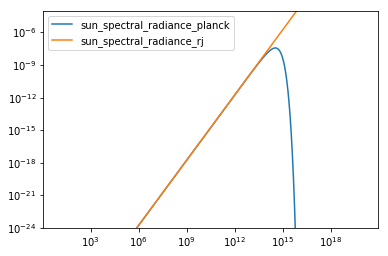

In [10]:
sun_df[["sun_spectral_radiance_planck", "sun_spectral_radiance_rj"]][0:1e20].plot(use_index=True, logx=True, logy=True, ylim=(1e-24, 1e-4))

### Monochromatic luminosity

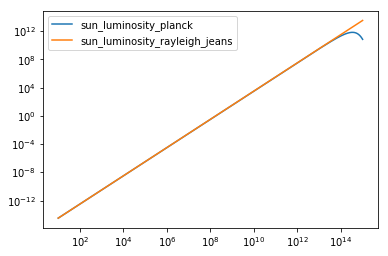

In [11]:
sun_df[["sun_luminosity_planck", "sun_luminosity_rayleigh_jeans"]][0:1e15].plot(use_index=True, logx=True, logy=True)

### Flux

Flux for a star computed using formula from Cocconi & Morrison follows the same slope as Rayleigh-Jeans law but values are higher. 

The flux for the galactic background radiation has the inverse relationship to frequency. There is a point where the flux from a star equals the flux from galactic background. This gives the minimum frequency for transmission of interstellar communications since any frequency below this will be indistinguishable from the galactic background. The minimum frequency varies according to the temperature and radius of a star. 

- Hotter and larger stars have lower minimum frequencies (with higher flux)
- Smaller and cooler stars have higher minimum frequencies (with lower flux)

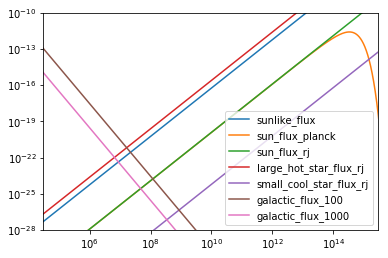

In [12]:
sun_df[["sunlike_flux", "sun_flux_planck",
        "sun_flux_rj", "large_hot_star_flux_rj",
        "small_cool_star_flux_rj",
        "galactic_flux_100", "galactic_flux_1000"]][1e-2:1e18].plot(use_index=True, logx=True, logy=True, ylim=(1e-28, 1e-10), xlim=(3e4, 3e15))

### Difference between Rayleigh-Jeans and Cocconi-Morrison

The flux is ~370 times higher using Cocconi & Morrison's formula.

If using the Rayleigh-Jeans law the formula would be:

$$ 2.6987 \times 10^{-18}f^2/R^2 $$  

The Cocconi & Morrison's formula is:

$$ 10^{-15}f^2/R^2 $$  

In their paper Cocconi & Morrison state their formula is based on the 'quiet Sun', not a blackbody. The Sun deviates from a blackbody at lower frequencies: there is a higher radiance that creates a bulge in the curve at approximately this order of magnitude.

### Varying star types
To compute the proportionality factor for minimum frequency for different star types in the formula we use:
$$ \left({c^4 10^{-12.5}}\over{2\pi k_B r^2T}\right)^{0.2} $$

$$ 5\times 10^8\over{\left({r^2T}\right)^{0.2}} $$

Where r is the radius of the star and T is the temperature of the star. The higher the temperature or the larger the radius, the lower the minimum frequency.


In [13]:
def constant_for_flux_calc(solar_radii, temperature):
    """Constant used to compute flux from Rayleigh-Jeans law given temperature and radius of a star.
    
    Used to multiply f^2/R^2 (where is frequency and R is distance to a star)
    
    Args:
        solar_radii: radius of star (solar radii)
        temperature: temperature of star (Kelvin)
    Returns:
        Factor used to calculate flux
    """
    return (2 * math.pi * pow(solar_radii * SUN_RADIUS, 2) * BOLTZMANN * temperature) / pow(LIGHT_SPEED, 2)

In [14]:
constant_for_flux_calc(1, SUN_TEMP)

2.6987839546541377e-18

In [15]:
constant_cocconi_morrison = 1e-15
quiet_sun_factor = constant_cocconi_morrison / constant_for_flux_calc(1, SUN_TEMP)
#quiet_sun_factor = 1
quiet_sun_factor

370.5372555944942

### Constant for different types of stars
Vary the radius and temperature

In [16]:
radii = np.logspace(-2, np.log10(2000), 100) # log10 solar radii
temperatures = np.linspace(2000, 50000, 1000)
stellar_constants = pd.DataFrame(constant_for_flux_calc(radii[:, None], 
                                                        temperatures) * quiet_sun_factor,
                                 index = np.around(radii, 2),
                                 columns=np.around(temperatures,0))

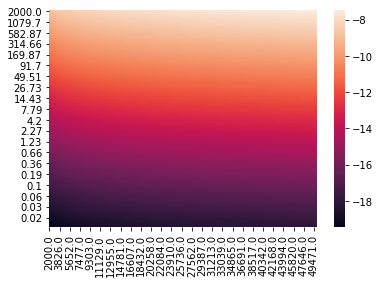

In [17]:
sns.heatmap(np.log10(stellar_constants)[::-1])

## Minimum frequency for different stars

Varying distances from Earth

### Minimum frequencies detectable at Earth's surface
The radio window for Earth puts a lower limit of 15 MHz ($1.5 \times 10^7$) and an upper limit of 1 THz ($1 \times 10^{12}$) for the frequency that can pass through Earth's atmosphere and reach detectors on the surface.


In [18]:
def constant_for_min_frequency(constant_for_flux):
    return pow((pow(3e8, 2) * pow(10, -12.5))/constant_for_flux, 0.2)

In [19]:
constant_for_min_frequency(1e-15)

7777.651902073661

In [20]:
min_freq_constants = constant_for_min_frequency(stellar_constants)

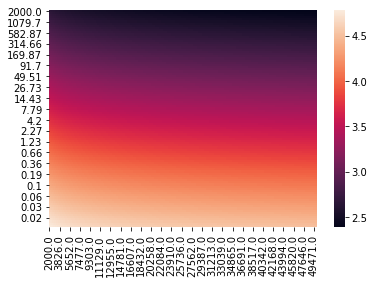

In [21]:
sns.heatmap(np.log10(min_freq_constants)[::-1])

### 10000 m2 detector

Current capabilities

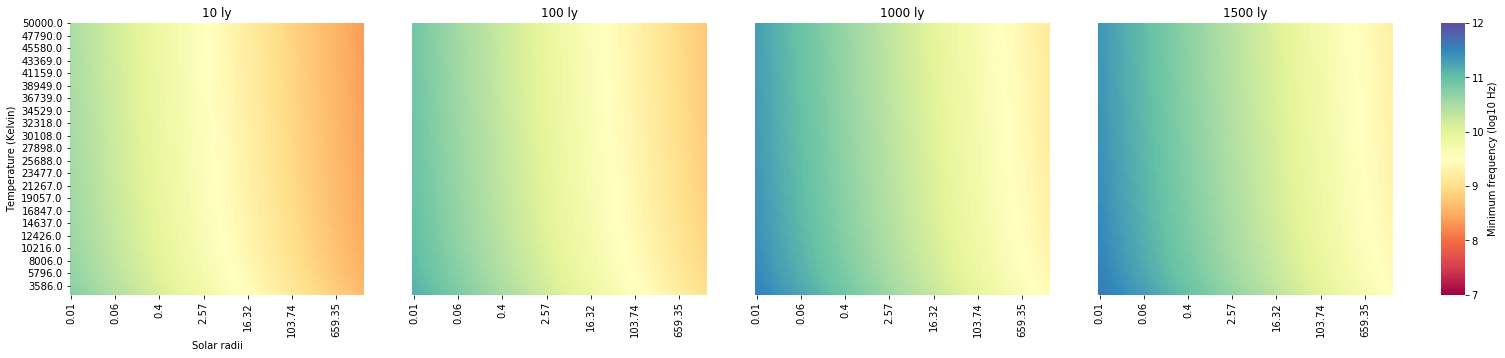

In [22]:
diameter_detector=100
freq_min = 7
freq_max = 12

fig, (ax1, ax2, ax3, ax4, axcb) = plt.subplots(1, 5, 
                                               gridspec_kw={'width_ratios':[1,1,1,1,0.08]})
ax1.get_shared_y_axes().join(ax2, ax3, ax4)


## 10 light years
g1 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=10,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax1, vmin=freq_min, vmax=freq_max, cbar=False, cmap="Spectral")
g1.set_title('10 ly')
g1.set_ylabel('Temperature (Kelvin)')
g1.set_xlabel('Solar radii')

## 100 light years
g2 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=100,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax2, vmin=freq_min, vmax=freq_max, cbar_ax=axcb, cmap="Spectral")
g2.set_title('100 ly')
g2.set_yticks([])

## 1000 light years
g3 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=1000,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax3, vmin=freq_min, vmax=freq_max, cbar_ax=axcb, cmap="Spectral",
                 cbar_kws={'label': 'Minimum frequency (log10 Hz)'})
g3.set_title('1000 ly')
g3.set_yticks([])

## 1500 light years
g4 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=1500,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax4, vmin=freq_min, vmax=freq_max, cbar_ax=axcb, cmap="Spectral",
                 cbar_kws={'label': 'Minimum frequency (log10 Hz)'})
g4.set_title('1500 ly')
g4.set_yticks([])

fig.set_figheight(5)
fig.set_figwidth(25)
plt.show()

### 1 km2 detector
Near future capabilities (SKA)

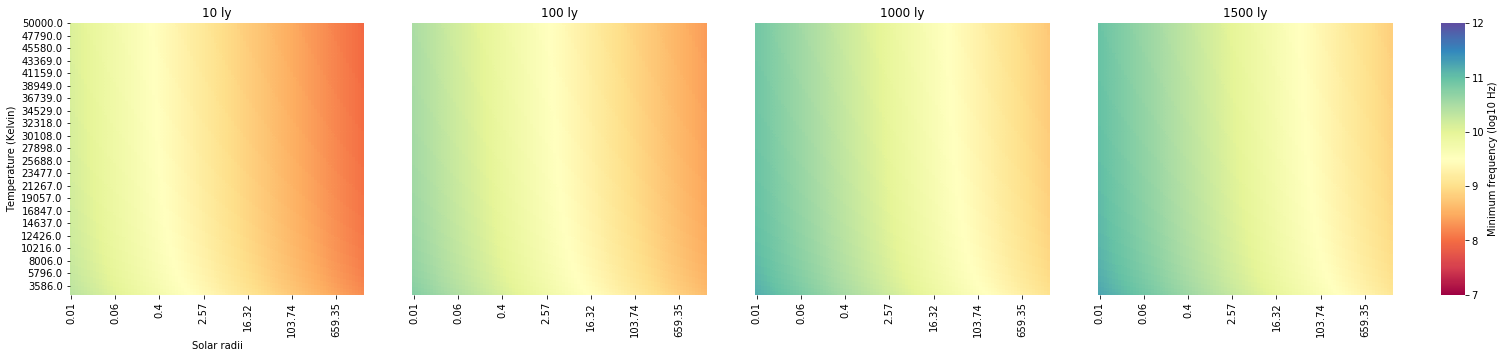

In [23]:
diameter_detector=1000
freq_min = 7
freq_max = 12

fig, (ax1, ax2, ax3, ax4, axcb) = plt.subplots(1, 5, 
                                               gridspec_kw={'width_ratios':[1,1,1,1,0.08]})
ax1.get_shared_y_axes().join(ax2, ax3, ax4)

## 10 light years
g1 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=10,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax1, vmin=freq_min, vmax=freq_max, cbar=False, cmap="Spectral")
g1.set_title('10 ly')
g1.set_ylabel('Temperature (Kelvin)')
g1.set_xlabel('Solar radii')

## 100 light years
g2 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=100,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax2, vmin=freq_min, vmax=freq_max, cbar_ax=axcb, cmap="Spectral")
g2.set_title('100 ly')
g2.set_yticks([])

## 1000 light years
g3 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=1000,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax3, vmin=freq_min, vmax=freq_max, cbar_ax=axcb, cmap="Spectral",
                 cbar_kws={'label': 'Minimum frequency (log10 Hz)'})
g3.set_title('1000 ly')
g3.set_yticks([])


## 1500 light years
g4 = sns.heatmap(np.log10(frequency_minimum(light_years_to_star=1500,
                                            diameter_detector=diameter_detector,
                                            constant=min_freq_constants)).T[::-1],
                 ax=ax4, vmin=freq_min, vmax=freq_max, cbar_ax=axcb, cmap="Spectral",
                 cbar_kws={'label': 'Minimum frequency (log10 Hz)'})
g4.set_title('1500 ly')
g4.set_yticks([])

fig.set_figheight(5)
fig.set_figwidth(25)
plt.show()

## Individual stars of interest

### Tabby's star


Minimum frequency for Tabby's star with 100m diameter detector = 10.65


[]

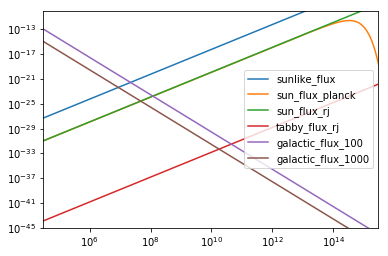

In [24]:
tabby_distance = 1447
tabby_temp = 6750
tabby_radius = 1.58

tabby_min_freq = np.log10(frequency_minimum(light_years_to_star=tabby_distance,
                          diameter_detector=100,
                          constant=constant_for_min_frequency(constant_for_flux_calc(tabby_radius, tabby_temp) 
                                                              * quiet_sun_factor)))

print(f"Minimum frequency for Tabby's star with 100m diameter detector = {round(tabby_min_freq, 2)}")

sun_df["tabby_flux_rj"] = [flux_from_luminosity(monochromatic_luminosity_rayleigh_jeans(freq, tabby_temp, tabby_radius * SUN_RADIUS),
                                                light_years_to_metres(tabby_distance)) * quiet_sun_factor
                           for freq in frequencies]

sun_df[["sunlike_flux", "sun_flux_planck",
        "sun_flux_rj",
        "tabby_flux_rj",
        "galactic_flux_100",
        "galactic_flux_1000" ]][1e-2:1e18].plot(use_index=True, logx=True, logy=True, ylim=(1e-45, 1e-10), xlim=(3e4, 3e15))
plt.plot()

## Summary

The minimum frequency required for us to detect a message above background radiation is inversely proportional to the radius and temperature of the host star:

$${f_{min}} \propto {{1}\over{r^{0.4}T^{0.2}}} $$

A message sent from a planet orbiting a smaller star will need a higher minimum frequency. 

The frequency increases further with increasing distance from Earth and decreases with the size of our detector. 

All minimum frequencies fall within the window that can pass through Earth's atmosphere.